# **Projet Python : prévision de la production éléctrique éolienne en France**
#### Florian Basso, Théo Ferry, Julien Peignon
***
L'objectif de ce projet est d'utiliser des données météorologiques de vents ainsi que des données liées au parc éolien français (position des éoliennes, puissance potentielle, etc..) afin de mettre en place des modèles de prédiction de la production d'énergie éolienne.
***
## 1) Données
### a) Récupération
Les données du Ministère de la Transition Écologique et de RTE sont en open data. Les données de Météo France sur les vents sont disponibles avec une API.

**Code à venir:** API données métérologiques, code téléchargement données éoliennes + données RTE

In [31]:
#Importation des librairies


!pip install pandas fiona shapely pyproj rtree  #Sur colab, sinon bug
# A faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales

!pip install contextily
!pip install geopandas
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug

from shapely.geometry import Point


import json
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import pytz

from cartiflette.download import get_vectorfile_ign


  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.
anaconda-client 1.11.0 requires urllib3>=1.26.4, but you have urllib3 1.22 which is incompatible.
aiobotocore 2.4.0 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.23.26 which is incompatible.
  Using cached botocore-1.27.59-py3-n

ImportError: cannot import name 'apply_request_checksum' from 'botocore.client' (/Users/lucius/opt/anaconda3/lib/python3.9/site-packages/botocore/client.py)

#### **1.** Récupération de l'historique la production d'électricité éolienne depuis 2015 - API RTE

Le but de ces premières lignes de code est de récupérer l'historique de la production d'électricité éolienne depuis 2015. On récupère ces données en passant par l'API de Réseau de Transport d'Electricité (RTE),le gestionnaire de réseau de transport français responsable du réseau public de transport d'électricité haute tension en France métropolitaine. 

L'API utilise une authentification Oauth 2.0 et nous avons du créer un compte et justifier notre démarche auprès de RTE pour obtenir des identifiants permettant de faire des requêtes à l'API. L'accès à l'API se fait par le protocole REST.


In [48]:
#Identifiants compte RTE (à ne pas diffuser)
client_id = "ac96732a-51ba-4487-91ee-755f22119c52"
client_secret = "12640de5-1bdf-411e-bc9d-905776c3557e"
url = "https://digital.iservices.rte-france.com/token/oauth/"


In [49]:
def get_access_token(url, client_id, client_secret):
    response = requests.post(
        url,
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )
    return response.json()["access_token"]


myToken = get_access_token(url, client_id, client_secret)

L'API RTE impose une limite sur la taille des données envoyées aux utilisateurs. Afin de contourner ce problème, on construit une boucle pour faire des requêtes sur l'API et append les résultats des requêtes à un dataframe.

Que le lecteur soit ici rassuré, elle ne prend que deux modestes minutes (peut-être encore moins sur les belles machines républicaines de l'INSEE) pour tourner.

In [54]:
#On définit plusieurs fonctions pour simplifier les conditions sur le code et rendre plus rapide son exécution

#fonction pour écrire les mois avec 0
def f(x):
    if len(x)<2:
        x = "0" + x
    return x

#fonction pour retourner les mois de débuts et de fin des échantillons que l'on souhaite
def caract(deb_mois,deb_annees):
    fin_annees = deb_annees
    deb_mois = f(deb_mois)
    fin_mois = str(int(deb_mois)+1)
    fin_mois=f(fin_mois)
    if int(fin_mois)>12: # Janvier de l'année d'après
        fin_mois = "01"
        fin_annees=str(int(deb_annees)+1)
    return deb_mois, deb_annees, fin_mois, fin_annees

base_url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/actual_generations_per_production_type?"

#on crée un dataframe vide auquel on va append les données RTE 
df1 = pd.DataFrame(columns = ['start_date', 'end_date', 'value'])

for i in range(2015,2023): 
    for j in range(1,13):
        #boucle sur les dates

        deb_mois = str(j)
        deb_annees = str(i)
        deb_mois,deb_annees, fin_mois, fin_annees = caract(deb_mois, deb_annees)
        
        #On brise la boucle pour le mois de décembre 2022 (données non disponibles)
        if deb_mois == "12" and deb_annees=="2022" :
            break
        

        #configuration URL API

        start_date = deb_annees + "-" + deb_mois + "-01T00:00:00%2B02:00"
        end_date = fin_annees + '-' + fin_mois + "-01T00:00:00%2B02:00" 
        complete_url = base_url + "start_date=" + start_date + "&end_date=" + end_date 

        #authentification

        head = {'Authorization': 'Bearer {}'.format(myToken)}
        response = requests.get(complete_url, headers=head)

        #formatage des données; de JSON à un dataframe
        json2 = response.json()
        df_rte = pd.json_normalize(json2['actual_generations_per_production_type'][10], 'values')
        df_rte['end_date'] = pd.to_datetime(df_rte['end_date'])
        df_rte['start_date'] = pd.to_datetime(df_rte['start_date'])

        #on merge les dataframes par les lignes
        df1 = [df1, df_rte]
        df1 = pd.concat(df1)



df1.head()

,start_date,end_date,value,updated_date
0,2015-01-01 00:00:00+01:00,2015-01-01 01:00:00+01:00,1314,NaN
1,2015-01-01 01:00:00+01:00,2015-01-01 02:00:00+01:00,1383,NaN
2,2015-01-01 02:00:00+01:00,2015-01-01 03:00:00+01:00,1464,NaN
3,2015-01-01 03:00:00+01:00,2015-01-01 04:00:00+01:00,1543,NaN
4,2015-01-01 04:00:00+01:00,2015-01-01 05:00:00+01:00,1579,NaN


On nettoie rapidement notre dataframe pour ne garder que les variables d'intérêt.

In [55]:
df1 = df1.drop(columns =['start_date', 'updated_date'])

df1

,end_date,value
0,2015-01-01 01:00:00+01:00,1314
1,2015-01-01 02:00:00+01:00,1383
2,2015-01-01 03:00:00+01:00,1464
3,2015-01-01 04:00:00+01:00,1543
4,2015-01-01 05:00:00+01:00,1579
...,...,...
689,2022-11-29 18:00:00+01:00,1550
690,2022-11-29 19:00:00+01:00,1618
691,2022-11-29 20:00:00+01:00,1587
692,2022-11-29 21:00:00+01:00,1601


In [72]:
df1=df1.rename(columns = {'end_date': 'time','value': 'production_eol'})

In [71]:
len(df1)
plt.plot(df1['time'],df1['production_eol'])


KeyError: 'time'

On transforme les dates qui étaient de type "string" en date, pour ce faire on les convertit avec le fuseau horaire universel.


In [63]:
#ici on convertit les dates au format UTC pour pouvoir les convertir au format date
#Cela n'aura pas d'incidence sur les moyennes mensuelles et annuelles.
df1['time'] = pd.to_datetime(df1['time'], utc=True)


In [75]:
#On les met au 
df1 = df1.set_index('time')
df1.head()



KeyError: "None of ['time'] are in the columns"

<AxesSubplot:xlabel='time'>

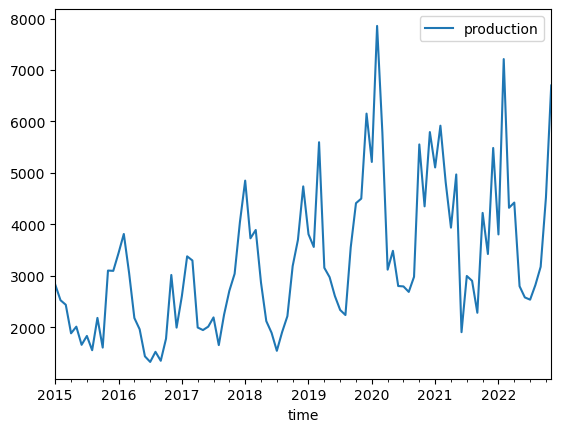

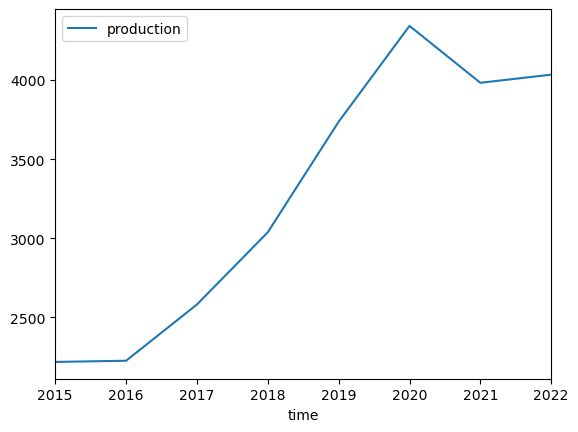

In [77]:
#On obtient les graphiques de moyennes mensuelles et annuelles
df1.resample('M').mean().plot()
df1.resample('Y').mean().plot()

Ces graphiques indiquent la moyenne horaire de production de la filière éolienne par mois et par an. 

On constate ici que la production électrique moyenne mensuelle a cru de manière continue (abstraction faite de la périodicité des vents pour le graphique n°1) de 2015 à 2020, année remarquablement ventée comme on le verra par la suite.
Les faibles vents de 2021, malgré la croissance du parc éolien français, sont à l'origine de la baisse de la production d'électricité éolienne .

In [80]:
#je laisse end mais bien garder en tête l'intervalle de temps



In [81]:
#Ce qu'il reste à faire :


## Sur le fond 
#intermittence du vent et de l'énergie en graphique -> implique de merge les données vents et énergie produite de RTE pour faire un double graphique croisé
#bien vérifier pourquoi il nous manque 4000 éoliennes dans la rég de Julien
#comprendre comment les données vents/production matchent 

##Sur la forme
#donner un titre à tous les graphiques
#structurer le notebook final (est ce qu'on structure comme le veut l'examen ? Répartition/Analyse descriptive/Modélisation
#commentaires et interprétations 
#clean les documents inutiles des repositories
#mettre un nouveau readme + stylé dans l'esprit de ce qu'ont fait clémence et benjamin

#### **2.** Récupération des données de vent - API Météo France


Avant de rentrer d'extraire l'entièreté des données nécessaires nous donnons un exemple d'utilisation de l'API pour récupérer les données de vent à une latitude/longitude et date données.

In [78]:
base_url = "https://archive-api.open-meteo.com/v1/era5?"
latitude=str(52.52)
longitude=str(13.41)
start_date="2022-06-08"
end_date="2022-12-04"
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date

reponse = requests.get(complete_url)
print(reponse.content)

b'{"latitude":52.5,"longitude":13.5,"generationtime_ms":0.48804283142089844,"utc_offset_seconds":0,"timezone":"GMT","timezone_abbreviation":"GMT","elevation":49.0,"hourly_units":{"time":"iso8601","windspeed_10m":"m/s"},"hourly":{"time":["2022-06-08T00:00","2022-06-08T01:00","2022-06-08T02:00","2022-06-08T03:00","2022-06-08T04:00","2022-06-08T05:00","2022-06-08T06:00","2022-06-08T07:00","2022-06-08T08:00","2022-06-08T09:00","2022-06-08T10:00","2022-06-08T11:00","2022-06-08T12:00","2022-06-08T13:00","2022-06-08T14:00","2022-06-08T15:00","2022-06-08T16:00","2022-06-08T17:00","2022-06-08T18:00","2022-06-08T19:00","2022-06-08T20:00","2022-06-08T21:00","2022-06-08T22:00","2022-06-08T23:00","2022-06-09T00:00","2022-06-09T01:00","2022-06-09T02:00","2022-06-09T03:00","2022-06-09T04:00","2022-06-09T05:00","2022-06-09T06:00","2022-06-09T07:00","2022-06-09T08:00","2022-06-09T09:00","2022-06-09T10:00","2022-06-09T11:00","2022-06-09T12:00","2022-06-09T13:00","2022-06-09T14:00","2022-06-09T15:00","20

### **a) Un exemple simple**

Maintenant que nous avons montré comment fonctionnait l'API, nous montrons comment nous allons nous servir de ces données météorologiques en prenant l'exemple de la première éoliennes de notre base de données. 

Ainsi, dans un premier temps, nous récupérons les données de vent pour cette éolienne précisément.

## **1) Les données sur les éoliennes**
### **a) Travail introductif sur la base de données**

Dans un premier temps, nous souhaitons décrire la répartition du parc éolien sur le territoire national (métropole seulement). Pour ce faire, nous allons créer une carte de la France et y afficher la position des éoliennes. 

On télécharge les données du Ministère de la Transition Ecologique et de la Cohésion des Territoires.

(https://www.georisques.gouv.fr/donnees/bases-de-donnees/eolien-terrestre)

In [14]:
import pandas as pd
df = pd.read_csv("eolien.csv", sep=";")

In [15]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaN,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


Ces données décrivent la position ainsi que certaines caractéristiques des éoliennes. Parmi ces caractérisques, celles qui nous intéressent dans notre objectif de prédiction de la production sont : la longueur des pales et le diamètre du rotor. La position des éoliennes nous permettra quant à elle d'associer chaque éolienne au vent auquel elle fait face. Dans la production d'énergie éolienne, le vent est évidemment la variable explicative la plus importante.

On convertit la colonne date_mise_en_service afin d'avoir des dates dans un format plus facilement interprétable.

In [16]:
import datetime

df.date_mise_en_service = pd.to_datetime((df.date_mise_en_service))

#### Rapide exploration des données et nettoyage

Certaines éoliennes de ce tableau ne sont pas encore en service.

In [17]:
df[df.date_mise_en_service > datetime.datetime.now()].count()

id_aerogenerateur        11
id_parc                  11
code_insee               11
nom_commune              11
code_dept                11
code_reg                 11
puissance                11
hauteur_totale           11
hauteur_mat_nacelle      11
diametre_rotor           11
cote_ngf                 11
periode_allumage_lib     11
periode_allumage_desc     0
type_feu_lib             11
type_feu_desc             0
date_mise_en_service     11
constructeur             11
reference_modele         11
x_aerogenerateur         11
y_aerogenerateur         11
epsg                     11
libelle                  11
date_maj                 11
nom_eolienne              0
dtype: int64

On voit qu'il n'y a que 11 éoliennes qui ne sont pas encore installées.
On les supprime de notre étude. 

In [18]:
df = df[df.date_mise_en_service.isna() | (df.date_mise_en_service < datetime.datetime.now())]

In [19]:
df['date_mise_en_service'].head()

0   2011-04-23
1   2014-04-01
2   2014-04-01
3   2014-04-01
4          NaT
Name: date_mise_en_service, dtype: datetime64[ns]

In [20]:
df.count()

id_aerogenerateur        7472
id_parc                  7472
code_insee               7472
nom_commune              7472
code_dept                7472
code_reg                 7472
puissance                7472
hauteur_totale           7472
hauteur_mat_nacelle      7472
diametre_rotor           7472
cote_ngf                 7472
periode_allumage_lib     7472
periode_allumage_desc       0
type_feu_lib             7472
type_feu_desc               0
date_mise_en_service     4320
constructeur             7472
reference_modele         7472
x_aerogenerateur         7472
y_aerogenerateur         7472
epsg                     7472
libelle                  7472
date_maj                 7472
nom_eolienne              347
dtype: int64

La variable 'puissance' indique la puissance installée en MégaWatt d'une éolienne, c'est la puissance maximale que celle-ci peut fournir. Les éoliennes les plus puissantes en France peuvent fournir aux alentours de 13MW. On constate que certaines observations ont des valeurs aberrantes pour la variable 'puissance', on les retire de notre échantillon.

In [21]:
df[df.puissance > 15].count()

id_aerogenerateur        18
id_parc                  18
code_insee               18
nom_commune              18
code_dept                18
code_reg                 18
puissance                18
hauteur_totale           18
hauteur_mat_nacelle      18
diametre_rotor           18
cote_ngf                 18
periode_allumage_lib     18
periode_allumage_desc     0
type_feu_lib             18
type_feu_desc             0
date_mise_en_service      8
constructeur             18
reference_modele         18
x_aerogenerateur         18
y_aerogenerateur         18
epsg                     18
libelle                  18
date_maj                 18
nom_eolienne              1
dtype: int64

In [22]:
df = df[df.puissance.isna() | (df.puissance < 15)]

In [30]:
df.count()

id_aerogenerateur        7454
id_parc                  7454
code_insee               7454
nom_commune              7454
code_dept                7454
code_reg                 7454
puissance                7454
hauteur_totale           7454
hauteur_mat_nacelle      7454
diametre_rotor           7454
cote_ngf                 7454
periode_allumage_lib     7454
periode_allumage_desc       0
type_feu_lib             7454
type_feu_desc               0
date_mise_en_service     4312
constructeur             7454
reference_modele         7454
x_aerogenerateur         7454
y_aerogenerateur         7454
epsg                     7454
libelle                  7454
date_maj                 7454
nom_eolienne              346
geometry                 7454
dtype: int64

Nos données décrivent 7454 éoliennes. Néanmoins, la date de mise en service n'est précisée que pour 4312 d'entre elles. Cela représente 58% de la base de données. 

Désormais, nous allons réaliser ces étapes pour chacune de nos éoliennes.

Nous convertissons nos données afin qu'elles soient exploitables par geopandas

On crée la variable geometry qui nous permettra de manipuler la position des éoliennes plus simplement.

In [27]:
geometrie = [Point(xy) for xy in zip(df.x_aerogenerateur,df.y_aerogenerateur)] # colonnes du DataFrame résultants
caract_eoliennes = gpd.GeoDataFrame(df,geometry=geometrie)
caract_eoliennes = caract_eoliennes.set_crs(2154, allow_override=True)

In [28]:
caract_eoliennes.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne,geometry
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN,POINT (371155.000 6786614.000)
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN,POINT (395860.280 6887806.500)
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN,POINT (395830.440 6886987.000)
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN,POINT (395760.560 6886064.000)
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN,POINT (463180.000 6547301.000)


In [25]:
#Le code est long à tourner et les données sont déjà fournies!

import csv

caract_eoliennes = caract_eoliennes.to_crs(4326)

base_url = "https://archive-api.open-meteo.com/v1/era5?"

end_date="2021-01-02"
end_date_comparaison = pd.to_datetime(end_date)
fichier_csv = open(r'C:\Users\theof\Desktop\ProjetPython\donnees_vent.csv','w',newline='')

writer = csv.writer(fichier_csv)

for eolienne in caract_eoliennes.itertuples():
    a = eolienne.geometry
    longitude=str(a.x)
    latitude=str(a.y)
    date = pd.to_datetime(eolienne.date_mise_en_service).date()
    if pd.isnull(date):
        start_date = "2021-01-01" 
    elif date < end_date_comparaison:
        start_date=str(max(date, pd.to_datetime("2021-01-01").date()))
        complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date
        reponse = requests.get(complete_url)
        donnees_vent_eolienne = pd.DataFrame(reponse.json())['hourly']
        writer.writerow([eolienne.Index,donnees_vent_eolienne['time'],donnees_vent_eolienne['windspeed_10m']])
    if eolienne.Index%50 == 0 : 
            print(eolienne.Index)


NameError: name 'caract_eoliennes' is not defined

Ici on réalise le même code que précédemment mais pour obtenir la météo prédite 

In [35]:
#Le code est long à tourner

import csv

caract_eoliennes = caract_eoliennes.to_crs(4326)

base_url = "https://api.open-meteo.com/v1/forecast?"

end_date_comparaison = pd.to_datetime(end_date)
fichier_csv = open(r'C:\Users\theof\Desktop\ProjetPython\donnees_vent_prediction.csv','w',newline='')

writer = csv.writer(fichier_csv)


start_date = "2022-12-13"

end_date = "2022-12-15"


for eolienne in caract_eoliennes.itertuples():
    a = eolienne.geometry
    longitude=str(a.x)
    latitude=str(a.y)
    date = pd.to_datetime(eolienne.date_mise_en_service).date()
    complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date
    reponse = requests.get(complete_url)
    donnees_vent_eolienne = pd.DataFrame(reponse.json())['hourly']
    writer.writerow([eolienne.Index,donnees_vent_eolienne['time'],donnees_vent_eolienne['windspeed_10m']])
    if eolienne.Index%50 == 0 : 
            print(eolienne.Index)

0
50


KeyboardInterrupt: 

In [24]:
caract_eoliennes = caract_eoliennes.to_crs(4326)

NameError: name 'caract_eoliennes' is not defined

In [70]:
a = caract_eoliennes.geometry[0]
print(a)
print(a.x)

POINT (-1.419713547794628 48.09705051237692)
-1.4197135477946279


In [71]:
latitude=str(a.y)
longitude=str(a.x)
start_date=str(pd.to_datetime(caract_eoliennes.date_mise_en_service[0]).date())
print(start_date)
end_date="2022-12-04"

2011-04-23


In [72]:
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date


import json
json.rep = requests.get(complete_url).json()

In [73]:
donnees_vent = pd.DataFrame(json.rep['hourly'])

donnees_vent['time'] = pd.to_datetime(donnees_vent['time'])
donnees_vent = donnees_vent.set_index('time')

donnees_vent.head()

,windspeed_10m
time,
2011-04-23 00:00:00,2.34
2011-04-23 01:00:00,2.33
2011-04-23 02:00:00,1.80
2011-04-23 03:00:00,1.84
2011-04-23 04:00:00,1.70


Pour cette éolienne, nous traçons la série temporelle du vent (vitesse moyenne sur 10mn heure par heure).

<AxesSubplot:xlabel='time'>

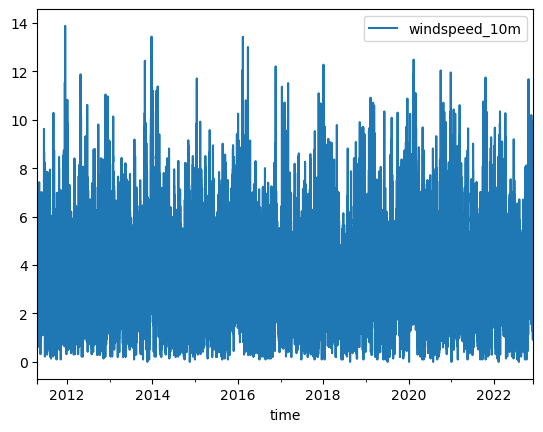

In [34]:
donnees_vent.plot()

On affiche également les moyennes de vent par an et par mois.

<AxesSubplot:xlabel='time'>

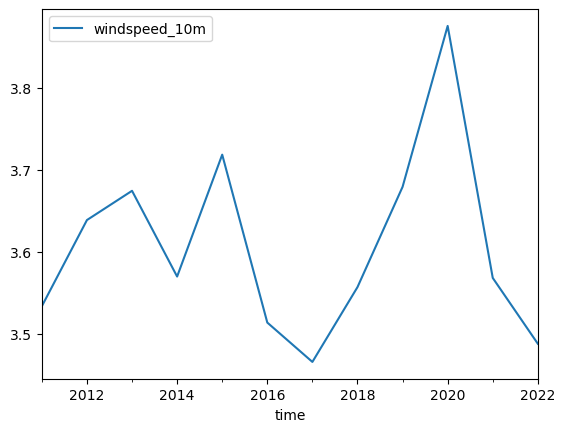

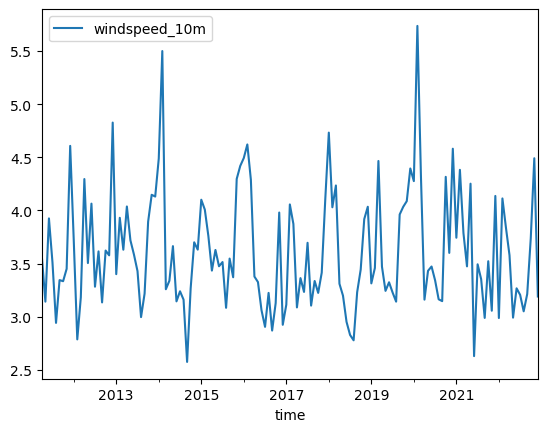

In [74]:
donnees_vent.resample('Y').mean().plot()
donnees_vent.resample('M').mean().plot()


Afin de calculer la production éléctrique (estimée) d'une éolienne à partir du vent qu'elle reçoit nous avons besoin de quelques notions de physique. 

La puissance d'une éolienne est donnée par $P = 1/2 \rho S V^3$ où $V$ est la vitesse du vent et $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 
Nous avons accès dans nos données à la longueur des pâles des éoliennes donc nous pouvons retrouver la puissance de l'éolienne.
L'énergie fournie sur une heure est donc cette puissance multipliée par le temps. Pour une éolienne, on peut considérer un facteur de charge de 16/27 (limite de Betz). Nous allons le prendre en compte pour calculer l'énergie fournie par une éolienne. 
Nous pourrions aller plus loin en prenant en compte la température et la pression qui influent sur la masse volumique de l'air $\rho$ et peuvent conduire à une variation de l'ordre de 20%.
Il serait également intéressant de regarder à la moyenne du vent par mois.

Nous créons une fonction qui calcule l'énergie produite (estimée) et nous affichons la série temporelle de cette énergie produite pour l'éolienne considérée dans cette exemple.

In [75]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * longueur_pale**2 * np.power(vitesse_vent,3)

In [76]:
diametre_rotor = caract_eoliennes['diametre_rotor'][0]
longueur_pale = caract_eoliennes['hauteur_totale'][0] - caract_eoliennes['hauteur_mat_nacelle'][0] # Je crois (Julien)

In [77]:
donnees_vent['energie'] = calcul_energie(diametre_rotor,donnees_vent['windspeed_10m'])

In [78]:
donnees_vent.index

DatetimeIndex(['2011-04-23 00:00:00', '2011-04-23 01:00:00',
               '2011-04-23 02:00:00', '2011-04-23 03:00:00',
               '2011-04-23 04:00:00', '2011-04-23 05:00:00',
               '2011-04-23 06:00:00', '2011-04-23 07:00:00',
               '2011-04-23 08:00:00', '2011-04-23 09:00:00',
               ...
               '2022-12-04 14:00:00', '2022-12-04 15:00:00',
               '2022-12-04 16:00:00', '2022-12-04 17:00:00',
               '2022-12-04 18:00:00', '2022-12-04 19:00:00',
               '2022-12-04 20:00:00', '2022-12-04 21:00:00',
               '2022-12-04 22:00:00', '2022-12-04 23:00:00'],
              dtype='datetime64[ns]', name='time', length=101856, freq=None)

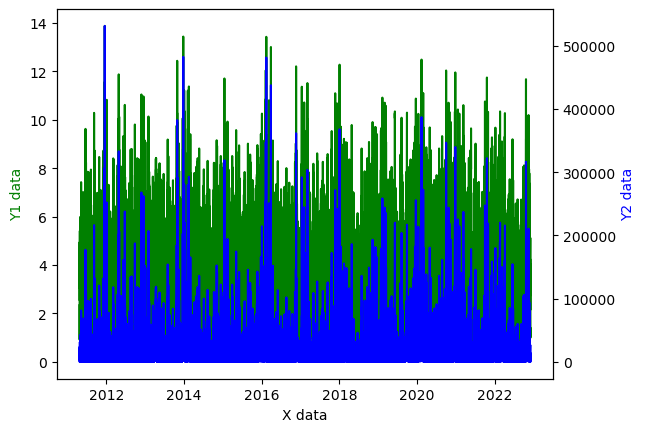

<AxesSubplot:xlabel='time'>

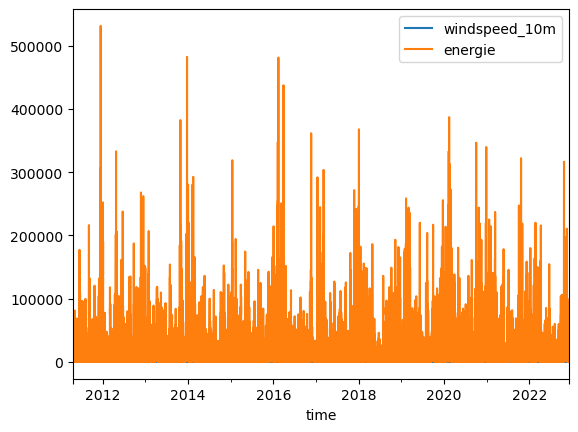

In [79]:
#Faire un graphique avec deux axes et deux échelles
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(donnees_vent.index, donnees_vent['windspeed_10m'], 'g-')
ax2.plot(donnees_vent.index, donnees_vent['energie'], 'b-')

ax1.set_xlabel('Années')
ax1.set_ylabel('Force du vent', color='g')
ax2.set_ylabel('Energie produite', color='b')


plt.show()

#graphique avec un seul axe
donnees_vent.plot()

Ce qui donne en moyennes mensuelles:

In [23]:
donnees_vent.resample('M').mean().plot()

donnees_vent.resample('Y').mean().plot()

#graphes croisés
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(donnees_vent.resample('Y').mean().plot(), 'g-')
ax2.plot(donnees_vent.resample('M').mean().plot(), 'b-')

ax1.set_xlabel('Années')
ax1.set_ylabel('Force du vent', color='g')
ax2.set_ylabel('Energie produite', color='b')


plt.show()



NameError: name 'donnees_vent' is not defined

### **b) Généralisation à toutes les éoliennes**

In [ ]:
###Ici fournir les données à Romain pour qu'il n'ait pas besoin de faire tourner le code si trop long

### b) Travail sur nos bases de données

L’enjeu sera de fusionner nos trois bases de données, de les retravailler de manière à associer les vents (qui sont mesurés à une localisation précise) aux éoliennes qui produisent dans un rayon proche afin d’estimer le plus finement possible la production en fonction des conditions météorologiques locales.

### c) Analyse descriptive

Premièrement, nous allons créer une carte afin de visualiser la position des installations éoliennes sur le territoire français

### **b) Description avec geopanda**

On affiche la position de nos éoliennes sans fond de carte, en l'occurence nous allons ajouter comme fond de carte la carte de la métropole française.

<AxesSubplot:>

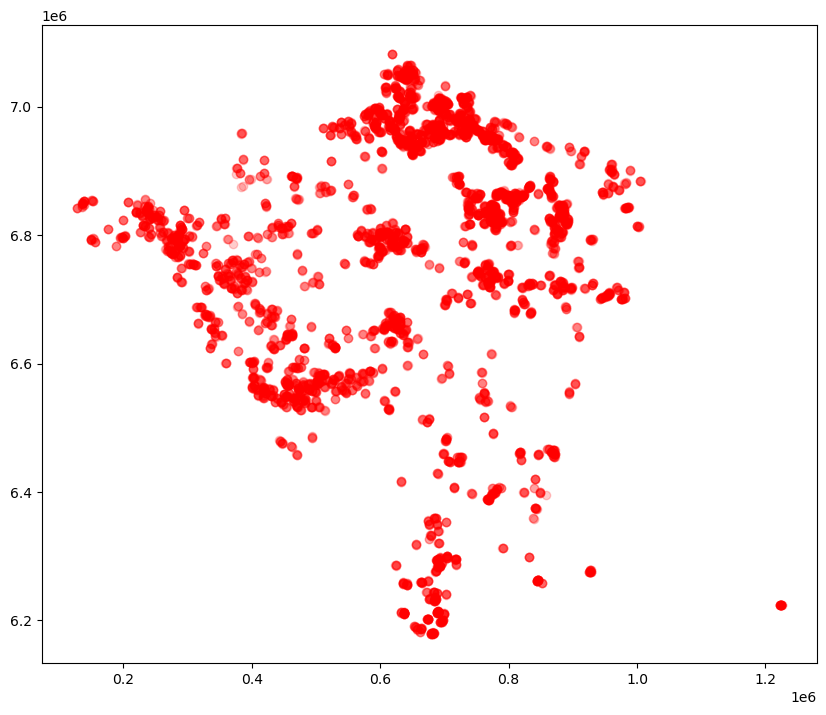

In [29]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

On rajoute désormais le fond de carte grâce au package Cartiflette.

Le génialissime package Cartiflette nous permet de télécharger les données geospatiales qui décrivent le contour de la métropole et de ses régions.

In [19]:
france = get_vectorfile_ign(
    field="metropole",
    level="REGION",
    year=2022)

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS_SHP_WGS84G_PACK_2022-06-21$ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21/file/ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21.7z


Downloading: : 563MiB [06:17, 1.56MiB/s] 


In [20]:
france = france[0:13] #On retire les outre-mers de la carte
france.head()

,ID,NOM_M,NOM,INSEE_REG,geometry
0,REGION_FXX_0000000000001,ILE-DE-FRANCE,Île-de-France,11,"POLYGON ((2.85612 49.07009, 2.85616 49.07011, ..."
1,REGION_FXX_0000000000002,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,"POLYGON ((1.70924 48.57802, 1.70934 48.57801, ..."
2,REGION_FXX_0000000000003,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,"POLYGON ((5.40561 47.64813, 5.40490 47.64851, ..."
3,REGION_FXX_0000000000004,NORMANDIE,Normandie,28,"MULTIPOLYGON (((-1.51486 48.66017, -1.51483 48..."
4,REGION_FXX_0000000000005,HAUTS-DE-FRANCE,Hauts-de-France,32,"POLYGON ((2.80921 49.09753, 2.80762 49.09682, ..."


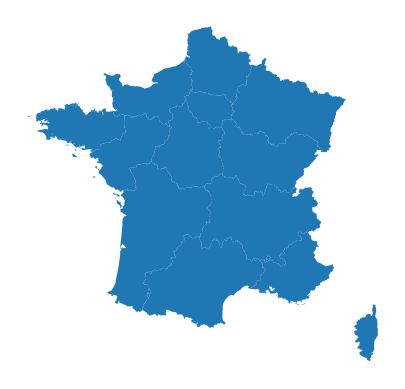

In [21]:
ax = france.plot()
ax.set_axis_off()

Enfin, nous ajoutons les éoliennes sur notre carte de France.

<AxesSubplot:>

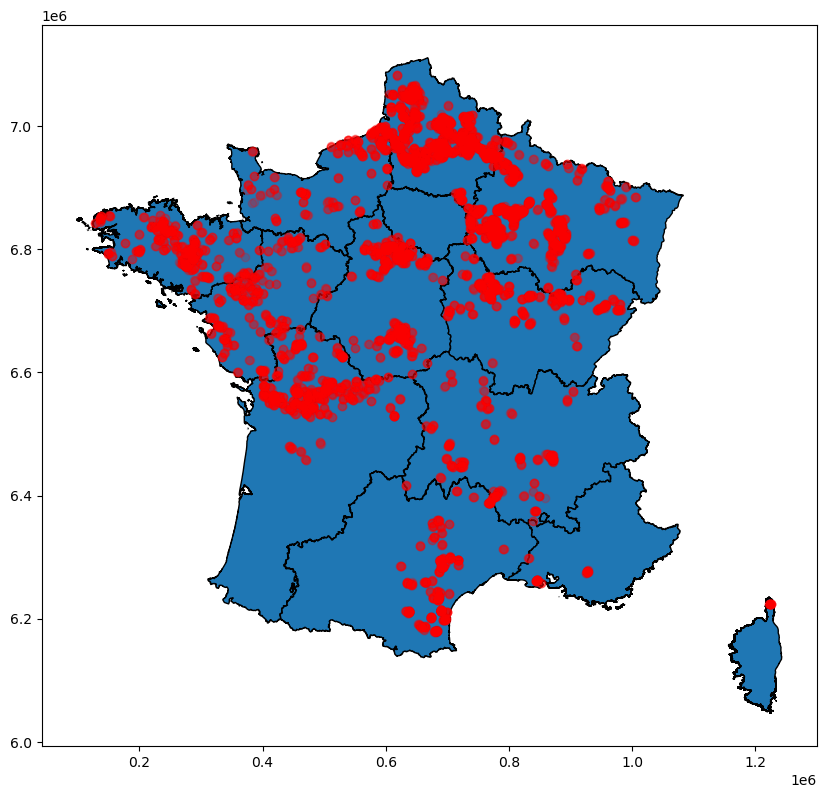

In [22]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")

### **c) Prise en compte de l'évolution du parc éolien dans le temps**

Nos données contiennent la date de mise en service de chaque éolienne. Cela nous permet d'aller plus loin que la simple description spatiale du parc éolien à un instant "t". Nous pouvons décrire l'évolution du parc éolien dans le temps.

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Dans un premier temps, nous affichons les 3152 éoliennes pour lesquelles nous ne connaissons pas leur date de mise en service. Comme nous l'avons dit, ces dernières représentent 42% du parc éolien. 

NameError: name 'france' is not defined

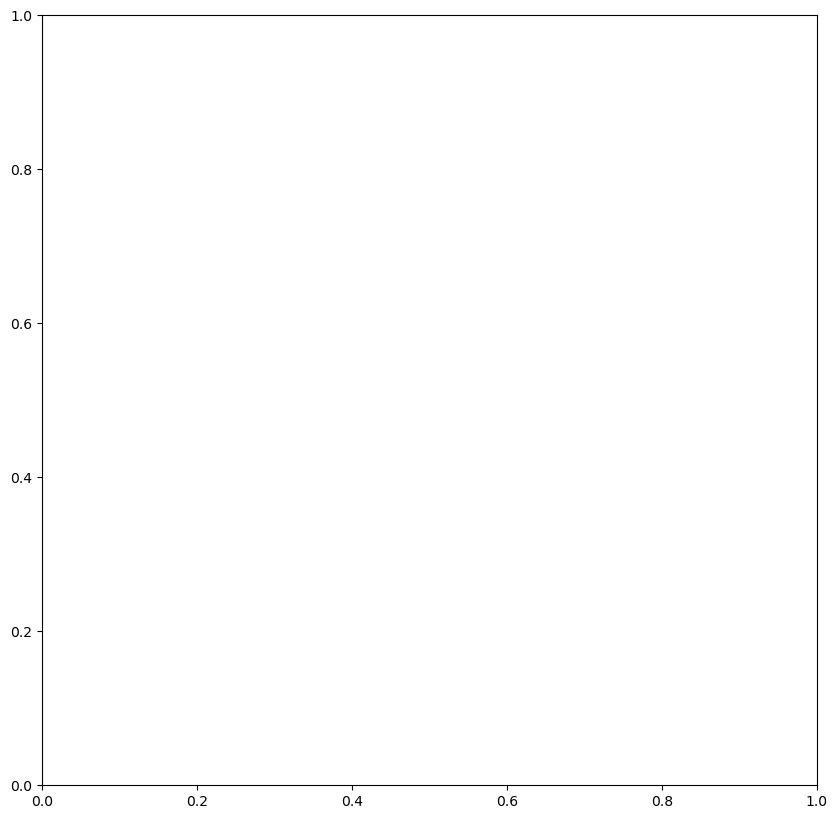

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

Pour celles dont nous connaissons la date, nous affichons l'évolution du parc d'éolienne en fonction du temps.

In [24]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))


from ipywidgets import interact

def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)   
    
interact(signal_plot,
            annee=periode)

interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>

En affichant celle dont on ne connait pas la date de mise en service en vert on obtient ce graphique :

In [25]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'green', alpha = 0.2, zorder=2)  
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)  

interact(signal_plot,
            annee=periode)

interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>

# **Modélisation statistique**
Cette partie visera à évaluer l'efficacité de notre approche afin de prédire la production éléctrique éolienne à partir de données météorologiques de vents. Pour ce faire, nous utiliserons dabord des méthodes de régréssions linéaires. Ensuite nous affinerons l'analyse en employant des techniques de machine learning.

### **1) Harmonisation des données**

Dans un premier temps, nous cherchons à harmoniser le format des dates des données météorologique et des données RTE. Le format recherché est, par exemple pour le 5 mai 2020 à 12h:

**2020-05-05:12:00**

Etant donné que le volume de données sur lesquels nous allons travailler et très important, nous avons dû utiliser le SSP cloud pour pouvoir faire tourner les codes ci-dessous sans rencontrer de memory error. Nous recommandons de faire de même.

#### **a) Données météorologiques**

In [1]:
import pandas as pd
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [2]:
#On télécharge les bases de données depuis un fichier public du SSP cloud
!wget https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_vent.csv
!wget https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_vent_prediction.csv

--2022-12-21 20:21:50--  https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_vent.csv
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.152, 192.168.253.151
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1667962847 (1.6G) [binary/octet-stream]
Saving to: ‘donnees_vent.csv.6’

donnees_vent.csv.6  100%[===================>]   1.55G   288MB/s    in 6.0s    

2022-12-21 20:21:56 (267 MB/s) - ‘donnees_vent.csv.6’ saved [1667962847/1667962847]

--2022-12-21 20:21:56--  https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_vent_prediction.csv
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.152, 192.168.253.151
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13949301 (13M) [binary/octet-stream]
Saving to: ‘donnees_vent_prediction.csv.5

In [3]:
#On importe les bases de données précedemment créées
donnees_vent = pd.read_csv('donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'])
donnees_vent_prediction = pd.read_csv('donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'])

In [4]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


In [5]:
donnees_vent_prediction.head()

,Index,Time,Windspeed
0,0,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.21, 3.23, 3.99, 2.79, 3.6, 3.42, 1.0, 2.24,..."
1,1,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
2,2,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
3,3,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.31, 2.84, 2.38, 2.33, 2.15, 1.93, 2.2, 2.24..."
4,4,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.74, 4.96, 4.8, 4.7, 4.39, 3.89, 2.91, 2.2, ..."


Le format des données est le suivant:

- L'index représente le numéro des éoliennes.

- La variable "Time" contient la liste de toutes les dates auxquelles on observe la vitesse du vent à la position de l'éolienne.

- La variable "Windspeed" contient la liste de la vitesse des vents.

On va chercher à "nettoyer" la variable "Time" afin de créer une liste de dates harmonisées. Avant cela, nous allons ajouter une colonne représentant la longueur du rotor de l'éolienne à partir de la précédente base de donnée "éolien.csv". Cela nous permettra plus tard de pondéré nos vents en fonction du diamètre du rotor de l'éolienne qui matérialise la "puissance potentielle" de cette dernière.

In [6]:
#On importe la base de données avec les diamètres des rotors
df = pd.read_csv("eolien.csv", sep=";")

In [7]:
#On fusionne les colonnes
donnees_vent = donnees_vent.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)
donnees_vent_prediction = donnees_vent_prediction.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)

Maintenant nous allons procéder à l'harmonisation, en terme de format, des données. Pour l'instant ces données sont considérées comme des string. Nous allons donc pouvoir retirer facilement les caractères qui nous posent problème.

On retire également les crochets et les virgules pour pouvoir ensuite diviser le string (ex: la liste de toutes les dates) en une liste de string (chaque date considéré comme un string séparé des autres) puis ensuite transformer cette liste de string en un élément de type list avec la fonction .tolist().

In [8]:
#On retire les caractères problématiques pour les dates
caracteres_time = ["'","[","]","T", ","]
    
for string in caracteres_time:
    donnees_vent["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))    

In [9]:
#On retire les caractères problématiques pour les vents
caracteres_vent = ["[", "]", ","]

for string in caracteres_vent:
    donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))

Maintenant que les variables "Time" et "Windspeed" sont nettoyées, on va utiliser la fonction explode afin d'avoir une base de données "classique" pour pouvoir faire des régressions. La fonction explode va nous permettre d'étendre les listes afin que chaque vent soit associé à l'éolienne qui le subit ainsi que la date à laquelle il a été mesuré.

Premièrement, on convertit nos données, considérées comme string, en liste.

In [10]:
#On convertit le string en une liste de string
donnees_vent["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].str.split(' ')

#On convertit la liste de string en une liste
donnees_vent["Time"] = donnees_vent["Time"].tolist()
donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].tolist()

In [11]:
#On convertit le string en une liste de string
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].str.split(' ')

#On convertit la liste de string en une liste
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].tolist()
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].tolist()

In [12]:
#On "explose" nos bases de données afin d'étendre les listes
donnees_vent = donnees_vent.set_index(['Index']).apply(pd.Series.explode).reset_index()
donnees_vent_prediction = donnees_vent_prediction.set_index(['Index']).apply(pd.Series.explode).reset_index()

In [13]:
#On reconvertit nos vents en float afin de pouvoir ensuite faire des régressions avec
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].astype(float)
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].astype(float)

#On reconvertit notre index en string pour ne pas qu'il nous emcombre plus tard quand on fera des moyennes de vents
donnees_vent["Index"] = donnees_vent["Index"].astype(str)
donnees_vent_prediction["Index"] = donnees_vent_prediction["Index"].astype(str)

Un élément important à garder en tête est que, à des vents trop faibles, les éoliennes ne produisent plus (vent < 12km/h) ainsi qu'à des vents trop élévés, afin de ne pas endommager les hélices (vent > 90km/h). Nos données de vitesse de vents sont exprimées en m/s. Nous devons donc "retirer" ces vents où les éoliennes ne produisent plus afin de ne pas biaiser nos estimatations.

In [14]:
#On définit la fonction qui retire les vents trop faibles
def inf(x):
    if x<3.33:
        return 0
    else:
        return x

#On définit la fonction qui retire les vents trop élevés
def sup(x):
    if x>25:
        return 0
    else:
        return x

In [15]:
#On applique la fonction qui retire les vents trops faibles aux données
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(inf)
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].apply(inf)

#On applique la fonction qui retire les vents trops élevés aux données
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(sup)
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].apply(sup)

Dans la formule théorique de la puissance d'une éolienne ($P = 1/2 \rho S V^3$) la vitesse du vent apparaît au cube. Nous allons donc considérer cette variable, la vitesse du vent au cube, dans nos analyses statistiques.
Dans cette même logique, le diametre du rotor apparaît au carré car c'est une surface ($S = \pi/4 d^2$), donc nous considérerons le carré du diamètre du rotor dans nos analyses. 

In [16]:
#On crée la variable de la vitesse du vent au cube
donnees_vent["Windspeed_cubed"] = donnees_vent["Windspeed"].pow(3)
donnees_vent_prediction["Windspeed_cubed"] = donnees_vent_prediction["Windspeed"].pow(3)

In [17]:
#On crée la variable du diamètre du rotor au carré
donnees_vent["rotor_carre"] = donnees_vent["diametre_rotor"].pow(2)
donnees_vent_prediction["rotor_carre"] = donnees_vent_prediction["diametre_rotor"].pow(2)

In [18]:
donnees_vent.head()

,Index,Time,Windspeed,diametre_rotor,Windspeed_cubed,rotor_carre
0,0,2021-01-0100:00,0.0,53.0,0.0,2809.0
1,0,2021-01-0101:00,0.0,53.0,0.0,2809.0
2,0,2021-01-0102:00,0.0,53.0,0.0,2809.0
3,0,2021-01-0103:00,0.0,53.0,0.0,2809.0
4,0,2021-01-0104:00,0.0,53.0,0.0,2809.0


Finalement nous avons pour chaque éolienne, la vitesse du vent à sa position pour chaque heure écoulée depuis sa mise en service. Comme nous allons le voir, les données de production éléctrique RTE sont différentes. Elles contiennent la production d'éléctricité éolienne nationale (agrégée) heure par heure. Ainsi, afin de pouvoir fusionner ces deux bases et de les étudier statistiquement, nous allons devoir agréger, au niveau nationale, nos données de vents.

A cette fin, nous allons faire la somme agrégée de la vitesse des vents au cube, pondérée par le diamètre du rotor au carré (qui matérialise la puissance potentielle de chaque éolienne). Ainsi, nous aurons, de la même manière que les données RTE qui sont moins précises, une vitesse du vent "totale" heure par heure au niveau nationale.

Cette manière de construire notre base de données représente bien sûr une approximation forte mais nécessaire car nous n'avons pas accès aux données de production éléctrique de chaque éolienne qui relèvent du secret commercial.

In [19]:
#On définit la fonction pour calculer la somme pondérée
def weighted_sum(group):
    d = group['rotor_carre']
    v = group['Windspeed_cubed']
    return (d*v).sum()

In [20]:
#On applique la fonction aux bases de données
vent_somme = donnees_vent.groupby(['Time']).apply(weighted_sum)
vent_somme_prediction = donnees_vent_prediction.groupby(['Time']).apply(weighted_sum)

In [21]:
#On reconvertit nos bases de données en dataframe
vent_somme = vent_somme.to_frame()
vent_somme_prediction = vent_somme_prediction.to_frame()

In [22]:
#On renomme la colonne qui contient désormais la somme de la vitesse des vents
vent_somme.columns = ['Windspeed_cubed']
vent_somme_prediction.columns = ['Windspeed_cubed']

In [23]:
vent_somme.head()

,Windspeed_cubed
Time,
2021-01-0100:00,2.620064e+07
2021-01-0101:00,3.802009e+07
2021-01-0102:00,7.566673e+07
2021-01-0103:00,8.818638e+07
2021-01-0104:00,1.021860e+08


Désormais nos données sont bien dans le format voulu, le même que celui des données RTE, à savoir:

- Une date associé à ...

- ... Une vitesse du vent au cube (somme nationale pondéré par le carré du diamètre du rotor)

#### **b) Données RTE**
On importe les données RTE auparavant obtenu grâce à l'API.

In [24]:
#On télécharge les données depuis un fichier public SSP cloud
!wget https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_rte.csv

--2022-12-21 20:24:07--  https://minio.lab.sspcloud.fr/jpeignon/ProjetPython/donnees_rte.csv
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.151, 192.168.253.152
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5723353 (5.5M) [binary/octet-stream]
Saving to: ‘donnees_rte.csv.3’

donnees_rte.csv.3   100%[===================>]   5.46M  --.-KB/s    in 0.05s   

2022-12-21 20:24:07 (118 MB/s) - ‘donnees_rte.csv.3’ saved [5723353/5723353]



In [25]:
data_RTE = pd.read_csv('donnees_rte.csv')

In [26]:
data_RTE.head()

,Unnamed: 0,start_date,end_date,value,updated_date
0,0,2015-01-01 00:00:00+01:00,2015-01-01 01:00:00+01:00,1314,NaN
1,1,2015-01-01 01:00:00+01:00,2015-01-01 02:00:00+01:00,1383,NaN
2,2,2015-01-01 02:00:00+01:00,2015-01-01 03:00:00+01:00,1464,NaN
3,3,2015-01-01 03:00:00+01:00,2015-01-01 04:00:00+01:00,1543,NaN
4,4,2015-01-01 04:00:00+01:00,2015-01-01 05:00:00+01:00,1579,NaN


In [27]:
#On ne garde que les données pour l'année 2021
data_RTE = data_RTE[data_RTE['start_date'].str.startswith('2021')]

#On remet à 0 la numérotation des lignes, ce qui va nous aider pour les boucles for
data_RTE = data_RTE.reset_index(drop=True)

On renomme les trois colonnes nécessaires et on enlève les colonnes inutiles.

In [28]:
#On retire les colonnes inutiles
columns_to_drop = ['end_date', 'updated_date']
data_RTE = data_RTE.drop(columns_to_drop, axis=1)

#On renomme les colonnes restantes
columns_to_rename = {'Unnamed: 0': 'Index', 'start_date': 'Time', 'value': 'Electricity'}
data_RTE = data_RTE.rename(columns=columns_to_rename)

Tout comme nos données de vents, on va charcher à harmoniser le format des dates car la fusion des données de vent et des données RTE se fera au niveau des dates.

In [29]:
#On retire les caractères problématiques
caracteres = ["+01:00"," ","+02:00"]
    
for string in caracteres:
    data_RTE["Time"] = data_RTE["Time"].apply(lambda x: x.replace(string, ''))

data_RTE["Time"] = data_RTE["Time"].str[:-3]

In [30]:
data_RTE.head()

,Index,Time,Electricity
0,0,2021-01-0100:00,1082
1,1,2021-01-0101:00,1075
2,2,2021-01-0102:00,1086
3,3,2021-01-0103:00,1149
4,4,2021-01-0104:00,1170


Les dates sont bien au format harmonisé voulu.

Finalement on va multiplié la colonne "Electricity" par 10 puissance 6 afin d'exprimer la production éléctrique dans une unité comparable à celle du vent. 

In [31]:
data_RTE['Electricity'] = (1e6)*data_RTE['Electricity']

#### **c) Fusion des deux bases de données**

In [32]:
#On crée notre base de données finales grâce à une fusion s'opérant sur la colonne des dates
data = data_RTE.merge(vent_somme, on='Time')

### **2) Les régressions linéaires**

#### **a) Spécification de base**

Rappelons que la puissance théorique d'une éolienne s'exprime de la manière suivante: $P = 1/2 B \rho S V^3$ où $V$ est la vitesse du vent et $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. B est la limite de betz, égale à $16/27$. Ainsi si l'on développe la formule:

$P = (1/2 B \rho  \pi/4)  (d^2 V^3)$

Ainsi, si l'on fait une régression linéaire de $P$ sur $V^3$, que l'on dénommera par la suite équation (1):

$P = \alpha_0 + \alpha_1 (d^2 V^3) + \epsilon$ (1)

On devrait retrouver:

- $\alpha_0=0$

- $\alpha_1=1/2 B \rho  \pi/4 = 0.2791$


De même si on régresse $ln(P)$ sur $ln(V)$, que l'on dénommera par la suite équation (2):

$ln(P) = \beta_0 + \beta_1 ln(d^2 V^3) + \eta$ (2)

On devrait retrouver:

- $\beta_0=ln(1/2 B \rho  \pi/4) = -1.2761$

- $\beta_1=1$

Nous allons donc faire ces deux régressions et voir si nos estimations se rapprochent de ce que nous devrions trouver théoriquement

#### **i) Estimation de l'équation (1)**

In [33]:
#On importe le package nécessaire
import statsmodels.formula.api as smf

#On définit une fonction pour faire des régression avec constante
def regression_results(x, y, z):
    model = smf.ols(y+"~"+z, data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())

#On définit une fonction pour faire des régressions sans constante
def regression_results_no_cte(x, y, z):
    model = smf.ols(y+"~"+z+"-1", data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())

Dans nos deux fonctions, nous avons choisi l'option cov_type='HC1'. Cette option permet d'obtenir des estimations robustes à l'hétéroscédasticité. Comme nous allons le voir avec les graphiques ci-dessous, la dispersion de nos résidus n'est pas homogène. Ainsi, avoir des estimateurs robustes à l'hétéroscédasticité paraît pertinent.

In [34]:
#On affiche les résultats de notre estimation de l'équation (1), sans constante car théoriquement alpha=0
regression_results_no_cte(data, "Electricity", "Windspeed_cubed")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.764
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              2371.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        20:24:08   Log-Likelihood:                     -1.9881e+05
No. Observations:                8640   AIC:                                  3.976e+05
Df Residuals:                    8639   BIC:                                  3.976e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

Le coefficient associé à la vitesse du vent (au cube) est 0.920. Il est statistiquement significatif à tous les seuils usuels. Ce coefficient ne correspond pas à celui auquel on s'attendait, à savoir $\alpha_1=1/2 B \rho  \pi/4 = 0.2791$.

En effet, notre approche comporte des limites que nous énumérons ici et auxquels nous ferons référence dans ce qui suit afin de ne pas se répéter:

- Nous faisons la moyenne des vitesses des vents car nous y sommes contraints mais cela implique une perte d'information considérable qui ne permet pas d'avoir des estimations fiables.

- Les vents sont mesurés à 10m du sol. Le vent que reçoit l'éolienne à hauteur de ses pâles peut différer et fausser nos prédictions.

- L'API des données météorologiques nous permet d'obtenir la vitesse des vents à n'importe quelle position en effectuant des interpolations à partir de mesures de vents à des stations météorologiques. Cette méthode d'interpolation peut également introduire des approximations à celles déjà citées.

- La limite de Betz $B=16/27$ ne fait pas consensus pour évaluer la production des éoliennes.

- La masse volumique de l'air $\rho$ peut varier en fonction de critères que nous n'obervons pas.

Pour toutes ces raisons, nous ne pouvons pas établir des estimations extrêmement précises de la production éléctrique éolienne, même si les estimations que nous trouvons sont tout à fait correctes.

Ensuite nous allons créer le graphique de cette régression.

In [35]:
#On importe le package nécessaire
import seaborn as sns

#On définie une fonction qui affiche le graphique d'une régression
def plot_linear_regression(x, y, z):
    plot = sns.regplot(x=z, y=y, data=x)
    return plot

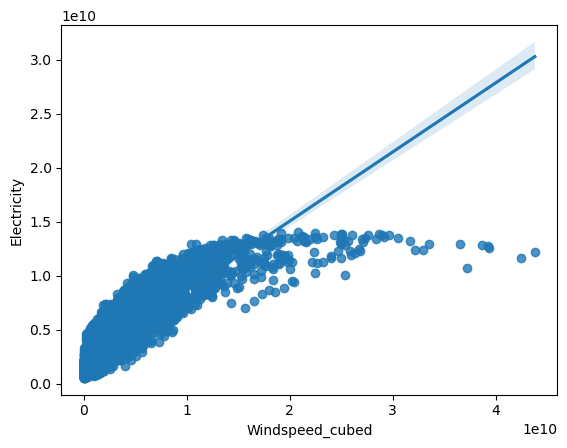

In [36]:
#On affiche le graphique de l'équation (1)
plot = plot_linear_regression(data, "Electricity", "Windspeed_cubed")

Notre régression approxime bien le début de la distribution de nos données. Néanmoins sa linéarité l'empêche de s'adapter à la courbure des données et au fait qu'au delà d'une certaine vitesse de vent, les éoliennes atteignent leur régime maximum, leur production maximale et ne produisent pas plus d'éléctricité si la vitesse du vent augmente. Ce "plateau" ne peut être étudié grâce à une régression linéaire.

Néanmoins on peut voir que la distribution des données s'apparente à une distribution logarithmique. C'est l'objet de notre équation (2).

#### **ii) Estimation de l'équation (2)**

Afin d'estimer l'équation (2), il va dabord falloir retravailler un peu les données pour les passer au logarithme.

In [37]:
#On importe le package nécessaire
import numpy as np

#On passe les données de production éléctrique au logarithme
data['Electricity_log'] = np.log(data['Electricity'])

In [38]:
#On créer une autre base de données qui ne contient que les valeurs positives de vitesse de vent afin de ne pas avoir d'erreurs avec le logarithme
data_log = data[data['Windspeed_cubed']>0]

In [39]:
#On crée ensuite de la même manière la variable de vitesse du vent au logarithme en divisant par trois pour retirer le cube
data_log['Windspeed_log'] = np.log(data_log['Windspeed_cubed'])

/tmp/ipykernel_1049/3632206529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_log['Windspeed_log'] = np.log(data_log['Windspeed_cubed'])


In [40]:
#On affiche les résultats de notre estimation de l'équation (2), avec constante
regression_results(data_log, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                 1.124e+04
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:24:09   Log-Likelihood:                -4346.6
No. Observations:                8596   AIC:                             8697.
Df Residuals:                    8594   BIC:                             8711.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.2884      0.073    196.404

Pour rappel, nous sommes censés trouver:

- $\beta_0=ln(1/2 B \rho  \pi/4) = -1.2761$

- $\beta_1=1$

On constate que le coefficient associé à la vitesse du vent au cube est éloignée de 1 et statistiquement significatif. La constante est, quant à elle, très problématique car elle est très élevée par rapport à ce qu'on attendait. Elle est également statistiquement significatif à tous les seuils usuels. Comme évoqué précédemment, nous pouvons penser que ces divergences entre la théorie et les résultats obtenus proviennent des approximations citées.

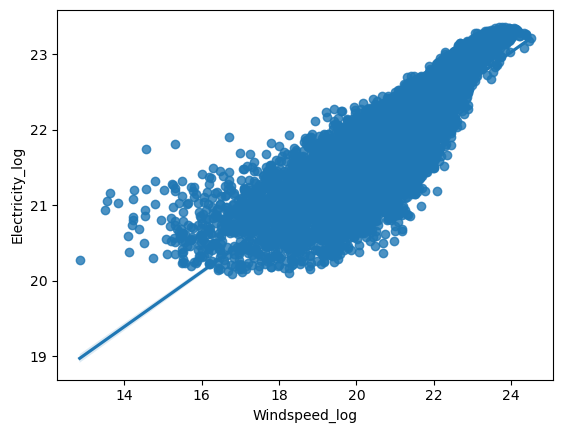

In [41]:
#On affiche le graphique de l'équation (2)
plot = plot_linear_regression(data_log, "Electricity_log", "Windspeed_log")

On voit qu'une régression linéaire explique mieux nos données lorsqu'elles sont sous forme logarithmique. Ce graphique permet également de bien montrer l'hétéroscédasticité des résidus. En effet la dispersion de la production éléctrique diminue au fur et à mesure que la vitesse du vent augmente. C'est pourquoi nous avons décidé d'estimer des régressions robustes à l'hétéroscédasticité.

#### **c) Deuxième spécification : régression coudée**

Grâce au graphique de l'équation (1), on se rend compte que la relation entre le vent et la production éléctrique n'est pas linéaire. Dans un premier temps elle l'est puis la production éléctrique atteinds un plafond et se stabiliser à un niveau de production maximum.

Il paraît donc pertinent de faire une régression coudée: une régression où la pente de la courbe va changer en un point précis. Nous allons procéder en trois étapes pour réaliser cette régression coudée:

-Nous déterminerons le lieu de la "cassure" grâce à un arbre de décision

-Nous estimerons les coefficients de la régression avant et après la cassure

-Nous afficherons le graphique de la régression coudée et superposans les regressions avant/après la cassure

#### **i) Détermination du point de cassure**

Premier étape: déterminer le point de cassure grâce à un arbre de décision

In [42]:
#On importe le package nécessaire
from sklearn.tree import DecisionTreeRegressor

#On définie le modèle d'arbre de décision que l'on souhaite, en l'occurence on ne cherche à avoir qu'une seule cassure
model_cassure = DecisionTreeRegressor(min_samples_leaf=10, max_depth=1)

In [43]:
#On convertit nos colonnes dans le format demandé par l'arbre de décision
X = data['Windspeed_cubed'].to_numpy()
X = X.reshape(-1, 1)
y = data['Electricity'].to_numpy()

In [44]:
#On fait tourner le modèle d'arbre de décision sur nos données
model_cassure.fit(X, y)
y_cassure = model_cassure.predict(X)

Nous allons maintenant afficher où l'arbre de décision réalise la cassure dans nos données

In [45]:
#On importe le package nécessaire
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


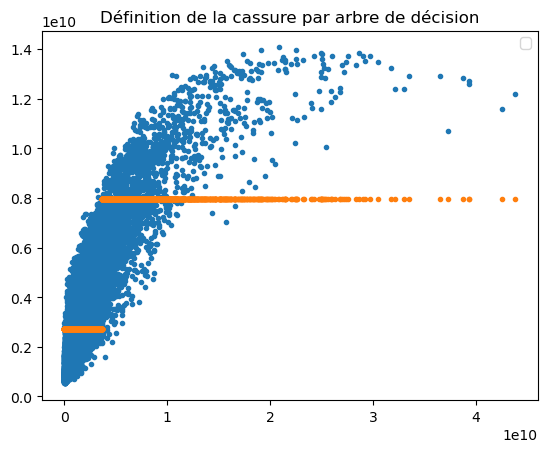

In [46]:
#On trace le graphique
fig, ax = plt.subplots(1, 1)
ax.plot(X, y, ".")
ax.plot(X, y_cassure, ".")
ax.legend()
ax.set_title("Définition de la cassure par arbre de décision");

In [47]:
#On récupère l'ordonnée où la cassure doit se faire
cassure = list(sorted(set(model_cassure.tree_.threshold)))
cassure += [(cassure[i] + cassure[i-1])/2 for i in range(1,len(cassure)-1)]
cassure = list(sorted(cassure))
cassure

[-2.0, 3626348672.0]

-2.0 est le point de départ de l'algorithme de l'arbre de décision. Ainsi, la cassure doit se faire au point d'ordonnée 3627853824, comme représenté sur le graphique ci-dessus.

#### **ii) Estimation de la régression linéaire avant et après la cassure**

Deuxième étape: estimé l'équation (1) par moindre carrés avant et après la cassure.

In [48]:
#On crée deux sous-dataset qui contiennent respectivement les données avant/après le point de cassure
data_inf = data[data['Windspeed_cubed']<cassure[1]]
data_sup = data[data['Windspeed_cubed']>cassure[1]]

In [49]:
#Résultats de la régression avant le point de cassure
regression_results_no_cte(data_inf, "Electricity", "Windspeed_cubed")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.788
Model:                            OLS   Adj. R-squared (uncentered):              0.788
Method:                 Least Squares   F-statistic:                          1.962e+04
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        20:24:10   Log-Likelihood:                     -1.4695e+05
No. Observations:                6532   AIC:                                  2.939e+05
Df Residuals:                    6531   BIC:                                  2.939e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

<AxesSubplot: xlabel='Windspeed_cubed', ylabel='Electricity'>

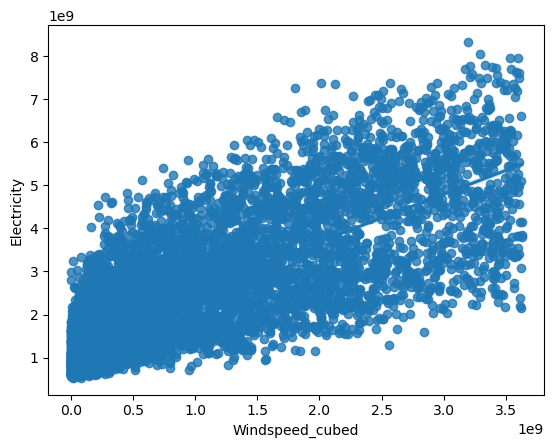

In [50]:
#Graphique de la régression avant le point de cassures
plot_linear_regression(data_inf, "Electricity", "Windspeed_cubed")

In [51]:
#Résultats de la régression après le point de cassure
regression_results(data_sup, "Electricity", "Windspeed_cubed")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     562.7
Date:                Wed, 21 Dec 2022   Prob (F-statistic):          1.92e-110
Time:                        20:24:10   Log-Likelihood:                -47808.
No. Observations:                2108   AIC:                         9.562e+04
Df Residuals:                    2106   BIC:                         9.563e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.204e+09   1.14e+08     

<AxesSubplot: xlabel='Windspeed_cubed', ylabel='Electricity'>

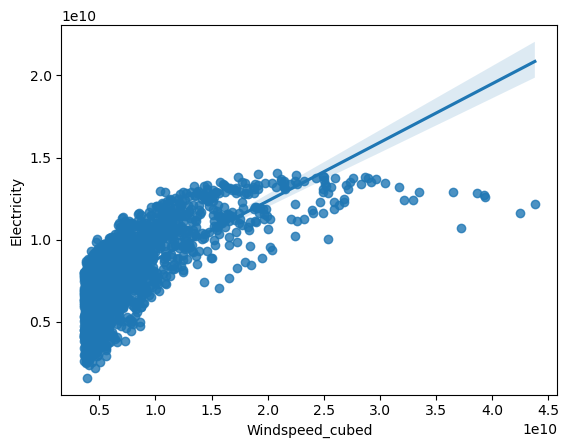

In [52]:
#Graphique de la régression après le point de cassures
plot_linear_regression(data_sup, "Electricity", "Windspeed_cubed")

#### **iii) Création de la régression coudée**

Troisième et dernière étape: la création de la régression coudée avec toutes les précédentes informations.

In [53]:
#On crée la droite définie par la régression linéaire avant la cassure
y_inf = 1.8428*data_inf['Windspeed_cubed']

#On crée la droite définie par la régression linéaire après la cassure
y_sup = 5.204e09+0.3573*data_sup['Windspeed_cubed']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Régression linéaire coudée')

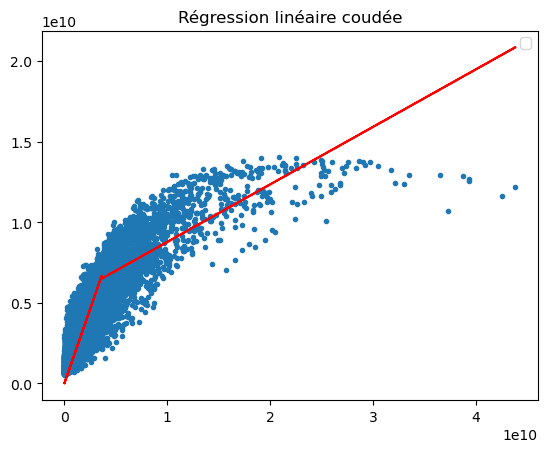

In [54]:
#On affiche ces deux droites en rouge avec nos points de données en bleu
fig, ax = plt.subplots(1, 1)
ax.plot(data['Windspeed_cubed'],data['Electricity'], ".")
ax.plot(data_inf['Windspeed_cubed'], y_inf, color='red')
ax.plot(data_sup['Windspeed_cubed'], y_sup, color='red')
ax.legend()
ax.set_title('Régression linéaire coudée')

La régression coudée permet de bien mieux définir nos données car elle considère en partie la relation non linéaire entre la vitesse du vent (au cube) et la production éléctrique. Elle permet également de prendre en compte le "plateau" de production maximum où un vent plus rapide n'augmente plus la production éléctrique.

#### **e) Troisième spécification : masse volumique de l'air**

Jusqu'à présent, nous n'avons pas utiliser toute la richesse de nos données. Nos données initiales comportent pour chaque éolienne: la vitesse du vent à sa position heure par heure ainsi que son diamètre de rotor. Pour l'instant, nous avons dû agréger les vents de toutes les éoliennes et ainsi, nous avons perdu beaucoup d'informations. 

Pour cette troisième spécification, nous allons directement régresser P sur lui-même: 

-Nous allons estimer, pour chaque éolienne, sa production éléctrique théorique heure par heure avec la formule: $P_{estimé} = 1/2 B \rho S V^3$

-Enfin nous allons régresser la production éléctrique mesuré par RTE à notre production éléctrique estimé:

$P = \gamma_0 + \gamma_1 P_{estimé} + \zeta$ (3)

On nommera par la suite cette régression, équation (3). Ainsi, théoriquement on devrait trouver:

- $\gamma_0 = 0$

- $\gamma_1 = 1$

L'intérêt de l'équation (3) est qu'elle nous permet d'exploiter toute la richesse de nos données. Nous pouvons calculer précisément la production théorique de chaque éolienne et ensuite l'agréger sans perdre d'informations comme lorsque nous agrégeons la vitesse des vents.

Ainsi dans un premier temps, nous allons devoir créer notre $P_{estimé}$

In [55]:
#On pose rho = 1.2
rho_air = 1.2

#On définie la fonction qui permet de calculer la production théorique d'une éolienne
def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * diametre_rotor**2 * np.power(vitesse_vent,3)

In [56]:
#On applique le calcul à nos données pour créer la variable 'Energie'
donnees_vent['Energie'] = calcul_energie(donnees_vent['diametre_rotor'],donnees_vent['Windspeed'])

In [57]:
#On crée un nouveau data frame sur lequel on va travailler pour estimer l'équation (3)
donnees_energie = donnees_vent

In [58]:
#On supprime les colonnes qui ne vont pas nous servir
columns_to_drop = ['Windspeed', 'diametre_rotor', 'rotor_carre', 'Windspeed_cubed']
donnees_energie = donnees_energie.drop(columns_to_drop, axis=1)

In [59]:
#On agrège la production calculée de chaque éolienne, pour avoir une production nationale heure par heure, comme les données RTE
energie_somme = donnees_energie.groupby(['Time']).sum()

/tmp/ipykernel_1049/2102944534.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energie_somme = donnees_energie.groupby(['Time']).sum()


In [60]:
#On fusionne les données de notre production théorique à celles de la production effective de RTE
data_energie = data_RTE.merge(energie_somme, on='Time')

In [61]:
data_energie.head()

,Index,Time,Electricity,Energie
0,0,2021-01-0100:00,1.082000e+09,7.316600e+06
1,1,2021-01-0101:00,1.075000e+09,1.061721e+07
2,2,2021-01-0102:00,1.086000e+09,2.113014e+07
3,3,2021-01-0103:00,1.149000e+09,2.462628e+07
4,4,2021-01-0104:00,1.170000e+09,2.853571e+07


Maintenant que nous avons crée notre base de données qui contient notre production théorique et la production effective heure par heure, nous allons pouvoir estimé l'équation (3) par OLS.

In [62]:
#On affiche les estimations de l'équation (3), sans constante car gamma_0 = 0
regression_results_no_cte(data_energie, "Electricity", "Energie")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.764
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              2371.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        20:24:18   Log-Likelihood:                     -1.9881e+05
No. Observations:                8640   AIC:                                  3.976e+05
Df Residuals:                    8639   BIC:                                  3.976e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

<AxesSubplot: xlabel='Energie', ylabel='Electricity'>

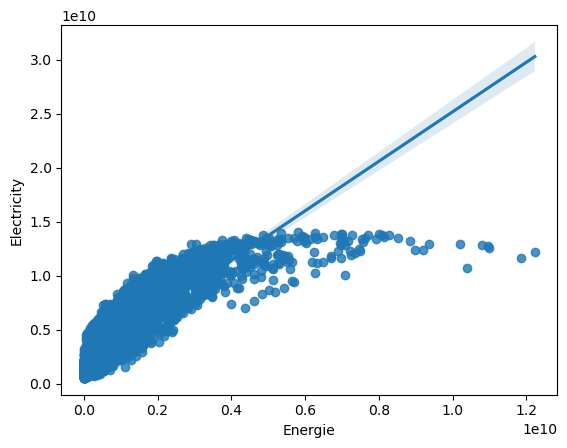

In [63]:
#On affiche le graphique de notre estimation de l'équation (3)
plot_linear_regression(data_energie, "Electricity", "Energie")

### **3) Machine learning: lasso regression**

Dans cette section, nous allons exploiter une source de données intéressantes: les vitesses du vents prévus. En effet, l'API sur laquelle nous avons récupérer nos données météorologiques contiennt également des données de prévision météorologique et entre autres, des vitesses de vent prévisionnelles. Les données prévisionnelles sont des données sur quatre jour.

Nous allons donc pouvoir entraîner un algorithme de machine learning sur nos données météorologiques observées et estimer la production éléctrique éolienne sur les quatre jours où nous avons des données prévisionnelles. A cette fin, nous allons utiliser un modèle simple de régression lasso. 

In [64]:
#On importe le package nécessaire
from sklearn.linear_model import Lasso

#On définie notre modèle
lasso_reg = Lasso()

#On entraîne notre modèle sur nos données
lasso_reg.fit(X, y)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.864e+21, tolerance: 7.109e+18
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [65]:
#On met nos prédictions de vent dans le bon format
X_pred = vent_somme_prediction['Windspeed_cubed'].to_numpy()
X_pred = X_pred.reshape(-1, 1)

#On définie nos prévisions d'électricité en fonction de nos prédictions météorologiques
y_pred_lasso = lasso_reg.predict(X_pred)

Text(0.5, 1.0, 'Lasso')

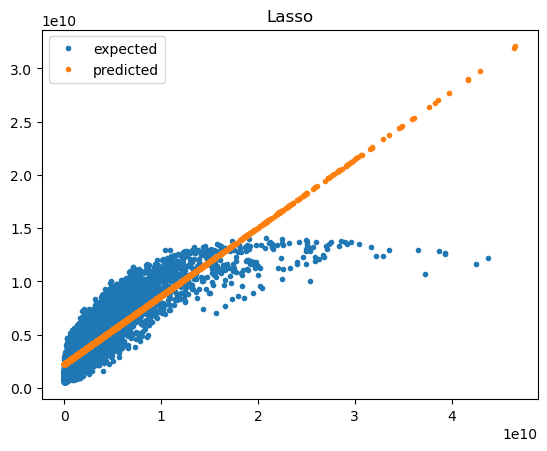

In [66]:
#On affiche la régression lasso
fig, lasso = plt.subplots(1, 1)
lasso.plot(X, y, ".", label="expected")
lasso.plot(X_pred, y_pred_lasso, ".", label="predicted")
lasso.legend()
lasso.set_title("Lasso")

Comme nous pouvions nous y attendre, la régression lasso n'apporte pas d'informations ni de profondeurs d'analyse supplémentaire par rapport aux différentes régressions linéaires déjà étudiées. La limite reste commune à toutes les techniques linéaires que nous avons considérées: ne pas être capable de prendre en compte la non-linéarité de la relation entre vent (au cube) et production éléctrique du au "plateau" de production des éoliennes.

# **Conclusion**